In [3]:
# Install the libraries
!pip install sentence_transformers
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install tf-keras

In [45]:
# Import the packages
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
from sklearn.manifold import TSNE
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, recall_score
from sklearn.model_selection import cross_validate
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow import keras
from tensorflow.keras import layers


# Federated Learning with Surgical Aggregation

## Setup

In [46]:
# Load the embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

In [47]:
# Load the datasets and create embeddings
file_path = r"data\IU-GroundTruth.csv"
report_column = 'REPORT'
df = pd.read_csv(file_path)
allReports = df[report_column]
allEmbeddings = [];

for report in allReports:
    response = model.encode(report)
    allEmbeddings.append(response)

label_columns = ['Enlarged Cardiom.','Cardiomegaly','Lung Lesion','Lung Opacity','Edema','Consolidation','Pneumonia','Atelectasis','Pneumothorax','Pleural Effusion','Pleural Other','Fracture','Support Devices']
labels = df[label_columns].values

allEmbeddings = np.array(allEmbeddings)
labels = np.array(labels)

In [48]:
# Create train and test sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(allEmbeddings, labels, test_size=test_size, random_state=37)

In [49]:
# Function to create an MLP classifier
def create_mlp_model(input_dim, output_dim):
    model = Sequential()

    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(512, activation="relu")(inputs)
    x = layers.Dropout(0.2)(x) # optional dropout
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x) # optional dropout
    outputs = layers.Dense(output_dim, activation="sigmoid")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)



    # Compile model
    model.compile(optimizer=Adam(),
                  loss=BinaryCrossentropy(),
                  metrics=[AUC(name='auc')])  # Use AUC as a metric

    return model

In [50]:
# Surgical Aggregation

def surgical_aggregation(nodes, max_label, global_model):

  """
  This function will surgically aggregate the last layer
  with the assumption that all the other layers
  are part of the representation block.

  Args:
    nodes: list of nodes with their models and label indices
    max_label: maximum number of labels / maximum label indice
    global_model: global model to update

  """

  # Extract the models and label indices from each node
  models = [node['classifier'] for node in nodes]
  labels = [node['label_names'] for node in nodes]

  # Identify the common and unique classes across all the models

  # Create a global final layer with all the labels
  lw = models[0].layers[-1].get_weights() # Get the last layer from one of the models
  row_shape = lw[0].shape[0] # Get the shape of the last layer
  final_layer_w = np.zeros((lw[0].shape[0],max_label+1)) # Use the last layer's shape to initialize the final layer for the global model
  final_layer_b = np.zeros(max_label+1) # Same for the bias

  node_count = np.zeros(max_label+1) # Number of contributing to each label



  num_layers = len(models[0].layers) # Get the number of layers
  for iter,layer in enumerate(models[0].layers): # iteratre through all the layers

    if isinstance(layer, tf.keras.layers.Dense): # Check if the layer type is a dense layer

      if iter == num_layers-1: # Check if this is the final layer (for surgical aggregation)

        # Surgically Aggregate the final layer


        node_count = np.zeros(max_label+1) # Initialize an array to count the number of nodes contributing to each label
        for iter1,model in enumerate(models): # iterate through all the models
          w = (model.layers[iter].get_weights()) # get the weights for the last layer
          w_0 = w[0] # get the weight matrix
          w_1 = w[1] # get the bias array

          for l_iter,l in enumerate(labels[iter1]): #iterate through all the labels in this model

            final_layer_w[:,l] += w_0[:,l_iter] # FedAvg on each label this model is contributing to
            final_layer_b[l] += w_1[l_iter]
            node_count[l] += 1

        for l in range(max_label+1):
          if node_count[l] > 0: # if this label has atleast one contributor
            final_layer_w[:,l] /= node_count[l] # perform fedavg
            final_layer_b[l] /= node_count[l] # perform fedavg

        for iter1,model in enumerate(models):
          fw = final_layer_w[:,labels[iter1]] # reassign the weights to each model
          fb = final_layer_b[labels[iter1]]
          model.layers[iter].set_weights([fw,fb])
        global_model.layers[iter].set_weights([final_layer_w,final_layer_b]) # assign the weights to the global model

      else:
        # Normal FedAvg for all other layers
        d_w = [] # for weights
        d_b = [] # for bias
        for model in models:
          d1 = model.layers[iter].get_weights()
          d_w.append(d1[0])
          d_b.append(d1[1])

        new_w = np.mean(d_w,axis=0)
        new_b = np.mean(d_b,axis=0)
        new_d = [new_w,new_b]

        for model in models:
          model.layers[iter].set_weights(new_d)
        global_model.layers[iter].set_weights(new_d)

  # Reassign the models to nodes
  for iter,node in enumerate(nodes):
    node['classifier'] = models[iter]

  return global_model, nodes

In [51]:
# Function to create the datasets for FL
def create_FL_Datasets(X_train, y_train, n_nodes, labels_shared):


  # Initialize the sample and label indices
  sample_indices = np.arange(0, X_train.shape[0])
  label_indices = np.arange(0, y_train.shape[1])

  # Let's shuffle the indices
  np.random.shuffle(label_indices)
  np.random.shuffle(sample_indices)

  # Picking the shared labels
  if labels_shared > 0:
    shared_labels = label_indices[:labels_shared]
    label_indices = label_indices[labels_shared:]
  else:
    shared_labels = []



  # Split the remaining labels into different nodes.
  label_indices_per_node = np.array_split(label_indices, n_nodes)


  # Split the dataset into different nodes
  sample_indices_per_node = np.array_split(sample_indices, n_nodes)

  # Let's create the nodes. Each node will store a dictionary of X_train, y_train,
  # and label_names
  nodes = []
  for i in range(n_nodes):
    node = {}
    node['X_train'] = X_train[sample_indices_per_node[i]]
    if len(shared_labels) > 0:
      node['y_train'] = y_train[np.ix_(sample_indices_per_node[i],np.concatenate((shared_labels,label_indices_per_node[i])))]
      node['label_names'] = np.concatenate((shared_labels,label_indices_per_node[i]))
    else:
      node['y_train'] = y_train[np.ix_(sample_indices_per_node[i],label_indices_per_node[i])]
      node['label_names'] = label_indices_per_node[i]

    node['classifier'] = create_mlp_model(node['X_train'].shape[1], node['y_train'].shape[1])
    nodes.append(node)

  return nodes

In [52]:
def get_metrics(model, X_test, y_test, labels):
    import numpy as np
    from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, roc_curve

    # Predict probabilities
    y_pred_proba = model.predict(X_test)
    y_true = y_test.copy()

    # Metrics calculation
    metrics = {}
    for i in range(labels.shape[1]):
        # Calculate the ROC curve to find optimal threshold
        fpr, tpr, thresholds = roc_curve(y_true[:, i], y_pred_proba[:, i])
        # Calculate Youden's J statistic for each threshold
        J = tpr - fpr
        optimal_idx = np.argmax(J)
        optimal_threshold = thresholds[optimal_idx]

        # Apply the optimal threshold to get binary predictions
        y_pred = (y_pred_proba[:, i] >= optimal_threshold).astype(int)

        # Accuracy
        accuracy = accuracy_score(y_true[:, i], y_pred)

        # Sensitivity (Recall for the positive class)
        sensitivity = recall_score(y_true[:, i], y_pred, pos_label=1)

        # Specificity: Recall for the negative class (pos_label=0)
        specificity = recall_score(y_true[:, i], y_pred, pos_label=0)

        # AUC (Area Under the ROC Curve)
        auc = roc_auc_score(y_true[:, i], y_pred_proba[:, i])

        # Store metrics for this label
        metrics[f'Label_{i}'] = {
            'Optimal Threshold': optimal_threshold,
            'Accuracy': accuracy,
            'Sensitivity': sensitivity,
            'Specificity': specificity,
            'AUC': auc
        }

    # Overall metrics
    metrics['Overall'] = {
        'Accuracy': np.mean([m['Accuracy'] for m in metrics.values() if isinstance(m, dict)]),
        'Sensitivity': np.mean([m['Sensitivity'] for m in metrics.values() if isinstance(m, dict)]),
        'Specificity': np.mean([m['Specificity'] for m in metrics.values() if isinstance(m, dict)]),
        'AUC': np.mean([m['AUC'] for m in metrics.values() if isinstance(m, dict)])
    }

    return metrics


In [53]:
def old_get_metrics(model, X_test, y_test, labels, threshold=0.5):
        # Predict probabilities
        y_pred_proba = model.predict(X_test)
        
        # Apply consistent threshold
        y_pred = (y_pred_proba >= threshold).astype(int)
        y_true = y_test.copy()

        # Metrics calculation
        metrics = {}
        for i in range(labels.shape[1]):
            metrics[f'Label_{i}'] = {
                'Accuracy': accuracy_score(y_true[:, i], y_pred[:, i]),
                'Sensitivity': recall_score(y_true[:, i], y_pred[:, i], pos_label=1),
                'Specificity': recall_score(y_true[:, i], y_pred[:, i], pos_label=0),
                'AUC': roc_auc_score(y_true[:, i], y_pred_proba[:, i])
            }
        
        # Overall metrics
        metrics['Overall'] = {
            'Accuracy': np.mean([m['Accuracy'] for m in metrics.values() if isinstance(m, dict)]),
            'Sensitivity': np.mean([m['Sensitivity'] for m in metrics.values() if isinstance(m, dict)]),
            'AUC': np.mean([m['AUC'] for m in metrics.values() if isinstance(m, dict)])
        }
        
        return metrics

# Experiment 1: Varying the number of nodes

In [54]:
# Federated Learning Experiment

# Input parameters

labels_shared = 0

num_epochs = 1
num_rounds = 20

allGlobalModels = []
allPerf = []
allLabelNames = []
allMetrics = []

for n_nodes in range(2, 11):

  # Create FL datasets
  nodes = create_FL_Datasets(X_train, y_train, n_nodes, labels_shared)

  # Initialize the global model
  global_model = create_mlp_model(allEmbeddings.shape[1], labels.shape[1])
  max_label = labels.shape[1]-1
  perf = global_model.evaluate(X_test,y_test)

  ### Perform federated learning
  # Iteratively train all models for N epochs and merge them using surgical aggregation

  for round in range(num_rounds):
    for node in nodes:
      node['classifier'].fit(node['X_train'], node['y_train'], epochs=num_epochs, verbose=0)

    print (n_nodes,round)

    # surgical aggregation FL
    global_model, nodes = surgical_aggregation(nodes, max_label, global_model)

  perf = global_model.evaluate(X_test,y_test)
  allGlobalModels.append(global_model)
  allPerf.append(perf)
  label_names = [node['label_names'] for node in nodes]
  allLabelNames.append(label_names)
  allMetrics.append(get_metrics(global_model, X_test, y_test, labels))

  print("performance of the global model after training: AUC=",perf[1], "Loss=", perf[0])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.4379 - loss: 0.6864 
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - auc: 0.9642 - loss: 0.1011
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
performance of the global model after training: AUC= 0.9645223021507263 Loss= 0.10296601802110672
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - auc: 0.4939 - loss: 0.6915
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
3 11
3 12
3 13
3 14
3 15
3 16
3 17
3 18
3 19
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - auc: 0.9644 - loss: 0.1037
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
performance of the global model after training: AUC= 0.9636107087135315 Loss= 0.10661164671182632
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - auc: 0.4619 - loss: 0.7007
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18
4 19
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - auc: 0.9537 - loss: 0.1211
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

In [55]:
# Train and evaluate the base model
base_model = create_mlp_model(allEmbeddings.shape[1], labels.shape[1])

base_model.fit(X_train, y_train, epochs=20, verbose=0)
base_perf = base_model.evaluate(X_test,y_test)
base_metrics = get_metrics(base_model, X_test, y_test, labels)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - auc: 0.9750 - loss: 0.0899
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


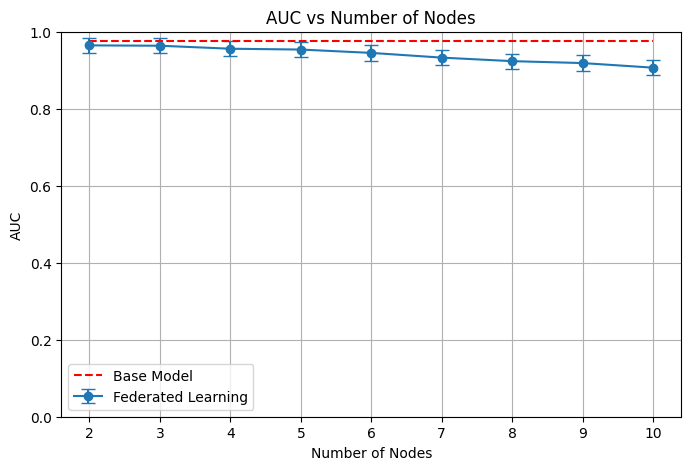

In [56]:
# Plot AUC vs. number of nodes using seaborn
perf_AUC = [x[1] for x in allPerf]
n_nodes = range(2,11)
plt.figure(figsize=(8, 5))

plt.errorbar(
    n_nodes,        # x-values
    perf_AUC,       # y-values (the means)
    yerr=np.std(perf_AUC, axis=0),   # error (standard deviation)
    fmt='-o',       # line and marker style
    capsize=5,      # adds "caps" to the error bars
    label='Federated Learning'
)

# Base model is a constant baseline (no error bars needed):
plt.plot(
    n_nodes,
    [base_perf[1]] * len(n_nodes),
    'r--',
    label='Base Model'
)

plt.xlabel('Number of Nodes')
plt.ylabel('AUC')
plt.title('AUC vs Number of Nodes')
plt.ylim(0, 1)
plt.xticks(n_nodes)
plt.legend()
plt.grid(True)
plt.show()


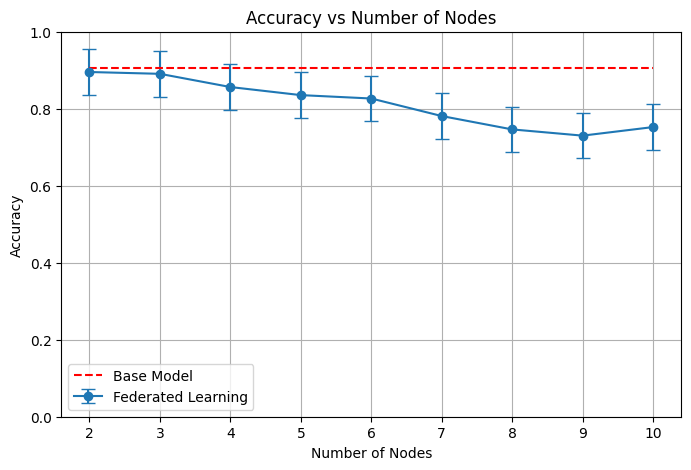

In [57]:
# Mean Accuracy vs. number of nodes
perf_Accuracy = [x['Overall']['Accuracy'] for x in allMetrics]

# For the base model
base_overall_accuracy = base_metrics['Overall']['Accuracy']

plt.figure(figsize=(8, 5))

plt.errorbar(
    n_nodes,
    perf_Accuracy,
    yerr=np.std(perf_Accuracy, axis=0),
    fmt='-o',
    capsize=5,
    label='Federated Learning'
)

plt.plot(
    n_nodes,
    [base_overall_accuracy] * len(n_nodes),
    'r--',
    label='Base Model'
)

plt.xlabel('Number of Nodes')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Nodes')
plt.ylim(0.0, 1.0)
plt.xticks(n_nodes)
plt.legend()
plt.grid(True)
plt.show()


## Storing Metrics

In [58]:
experiment_directory = os.path.join('data', 'Experiment 1')

os.makedirs(experiment_directory, exist_ok=True)

In [59]:
# Convert any NumPy arrays to lists
allPerf_serializable = [perf.tolist() if isinstance(perf, np.ndarray) else perf for perf in allPerf]

# Save to JSON
with open(os.path.join(experiment_directory, 'allPerf.json'), 'w') as f:
    json.dump(allPerf_serializable, f)


In [60]:
# Function to make data JSON serializable
def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64, np.int32, np.int64)):
        return obj.item()  # Convert NumPy scalars to native Python types
    else:
        return obj

# Convert allMetrics to a serializable format
allMetrics_serializable = make_serializable(allMetrics)

# Save to JSON
with open(os.path.join(experiment_directory, 'allMetrics.json'), 'w') as f:
    json.dump(allMetrics_serializable, f)


In [61]:
# Convert NumPy array to list if necessary
base_perf_serializable = base_perf.tolist() if isinstance(base_perf, np.ndarray) else base_perf

# Save to JSON
with open(os.path.join(experiment_directory, 'base_perf.json'), 'w') as f:
    json.dump(base_perf_serializable, f)


In [62]:
# Convert base_metrics to a serializable format
base_metrics_serializable = make_serializable(base_metrics)

# Save to JSON
with open(os.path.join(experiment_directory, 'base_metrics.json'), 'w') as f:
    json.dump(base_metrics_serializable, f)


## Storing Models

In [63]:
models_directory = os.path.join(experiment_directory, 'models')
os.makedirs(models_directory, exist_ok=True)

In [64]:
# Save each global model's architecture and weights
for idx, model in enumerate(allGlobalModels):
    # Save model architecture to JSON
    model_json = model.to_json()
    with open(os.path.join(models_directory, f'allGlobalModels_model_{idx}.json'), 'w') as json_file:
        json_file.write(model_json)
    # Save model weights to HDF5
    model.save_weights(os.path.join(models_directory, f'allGlobalModels_{idx}.weights.h5'))


In [65]:
# Save base model architecture to JSON
base_model_json = base_model.to_json()
with open(os.path.join(models_directory, 'base_model.json'), 'w') as json_file:
    json_file.write(base_model_json)

# Save base model weights to HDF5
base_model.save_weights(os.path.join(models_directory, 'base_model.weights.h5'))


# Experiment 2

In [66]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

## Running Model

In [68]:
def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    else:
        return obj


In [70]:
# Create the output directory if it doesn't exist
output_dir = 'data/Experiment 2'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# Experiment parameters
num_iterations = 20
num_rounds = 20
num_epochs = 1
labels_shared = 0
test_size = 0.2



all_experiment_results = []

for iteration in range(num_iterations):
    print(f"Running iteration {iteration + 1}...")
    
    # Initialize containers to store results for this iteration
    iteration_global_models = []
    iteration_perf = []
    iteration_label_names = []
    iteration_metrics = []
    
    # Federated Learning Experiment for this iteration
    for n_nodes in range(2, 11):
        nodes = create_FL_Datasets(X_train, y_train, n_nodes, labels_shared)
        global_model = create_mlp_model(allEmbeddings.shape[1], labels.shape[1])
        max_label = labels.shape[1] - 1
        
        # Perform federated learning
        for round in range(num_rounds):
            for node in nodes:
                node['classifier'].fit(node['X_train'], node['y_train'], epochs=num_epochs, verbose=0)
            global_model, nodes = surgical_aggregation(nodes, max_label, global_model)
        
        # Evaluate the global model
        perf = global_model.evaluate(X_test, y_test, verbose=0)
        iteration_global_models.append(global_model)
        iteration_perf.append(perf)
        label_names = [node['label_names'].tolist() for node in nodes]
        iteration_label_names.append(label_names)
        metrics = get_metrics(global_model, X_test, y_test, labels)
        iteration_metrics.append(metrics)
    
    # Convert data to JSON-serializable format
    iteration_perf_serializable = make_serializable(iteration_perf)
    iteration_label_names_serializable = make_serializable(iteration_label_names)
    iteration_metrics_serializable = make_serializable(iteration_metrics)
    
    # Store results of this iteration in a specific folder
    iteration_dir = os.path.join(output_dir, f'iteration_{iteration + 1}')
    os.makedirs(iteration_dir, exist_ok=True)
    
    # Save performance metrics as JSON
    with open(os.path.join(iteration_dir, 'iteration_perf.json'), 'w') as f:
        json.dump(iteration_perf_serializable, f)
    
    # Save label names as JSON
    with open(os.path.join(iteration_dir, 'iteration_label_names.json'), 'w') as f:
        json.dump(iteration_label_names_serializable, f)
    
    # Save detailed metrics as JSON
    with open(os.path.join(iteration_dir, 'iteration_metrics.json'), 'w') as f:
        json.dump(iteration_metrics_serializable, f)
    
    # Save global models
    models_dir = os.path.join(iteration_dir, 'models')
    os.makedirs(models_dir, exist_ok=True)
    for idx, model in enumerate(iteration_global_models):
        # Save model architecture to JSON
        model_json = model.to_json()
        with open(os.path.join(models_dir, f'global_model_{idx}.json'), 'w') as json_file:
            json_file.write(model_json)
        # Save model weights (weights cannot be saved as JSON)
        model.save_weights(os.path.join(models_dir, f'global_model_{idx}.weights.h5'))
    
    # Save iteration-level data for comparison
    experiment_data = {
        'perf': iteration_perf_serializable,
        'label_names': iteration_label_names_serializable,
        'metrics': iteration_metrics_serializable
    }
    all_experiment_results.append(experiment_data)

# Save all experiment results as JSON
all_experiment_results_serializable = make_serializable(all_experiment_results)
with open(os.path.join(output_dir, 'all_experiment_results.json'), 'w') as f:
    json.dump(all_experiment_results_serializable, f)

print("All 20 iterations are complete, and results are saved.")


Running iteration 1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running iteration 2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Running iteration 3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

## Comparing Results

In [71]:
with open('data/Experiment 2/all_experiment_results.json', 'r') as f:
    all_experiment_results = json.load(f)

# Access specific iteration results, for example, iteration 1:
iteration_1_results = all_experiment_results[0]  # Index starts at 0

# Print performance metrics for iteration 1
print(iteration_1_results['perf'])

[[0.10043995827436447, 0.9704200625419617], [0.09884420782327652, 0.9691283702850342], [0.11903730779886246, 0.9596276879310608], [0.1212288960814476, 0.9520751237869263], [0.14317353069782257, 0.9369339346885681], [0.15374141931533813, 0.9367430806159973], [0.15456616878509521, 0.9306057691574097], [0.16992516815662384, 0.9145715832710266], [0.1790066659450531, 0.9057651162147522]]


## Visualisation

In [72]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# Define the directory where the experiment data is stored
experiment_dir = 'data/Experiment 2'

# Load the overall results of all experiments
with open(os.path.join(experiment_dir, 'all_experiment_results.json'), 'r') as f:
    all_experiment_results = json.load(f)


all_auc = []      # To store AUC values across iterations
all_accuracy = [] # To store accuracy values across iterations

In [74]:
for experiment in all_experiment_results:
    perf_metrics = experiment['perf']
    auc_values = [perf[1] for perf in perf_metrics]  # Assuming AUC is at index 1 in 'perf'
    # Extract 'Accuracy' from 'metrics' dictionary for each node
    accuracy_values = [metric['Overall']['Accuracy'] for metric in experiment['metrics']]
    
    all_auc.append(auc_values)
    all_accuracy.append(accuracy_values)

In [75]:
# Convert lists to NumPy arrays for easy calculation of mean and std dev
all_auc = np.array(all_auc)
all_accuracy = np.array(all_accuracy)

# Calculate mean and standard deviation for AUC and Accuracy across all iterations
mean_auc = np.mean(all_auc, axis=0)
std_auc = np.std(all_auc, axis=0)

mean_accuracy = np.mean(all_accuracy, axis=0)
std_accuracy = np.std(all_accuracy, axis=0)

# Define the number of nodes used during the experiment
n_nodes = np.arange(2, 11)  # Node range from 2 to 10 inclusive

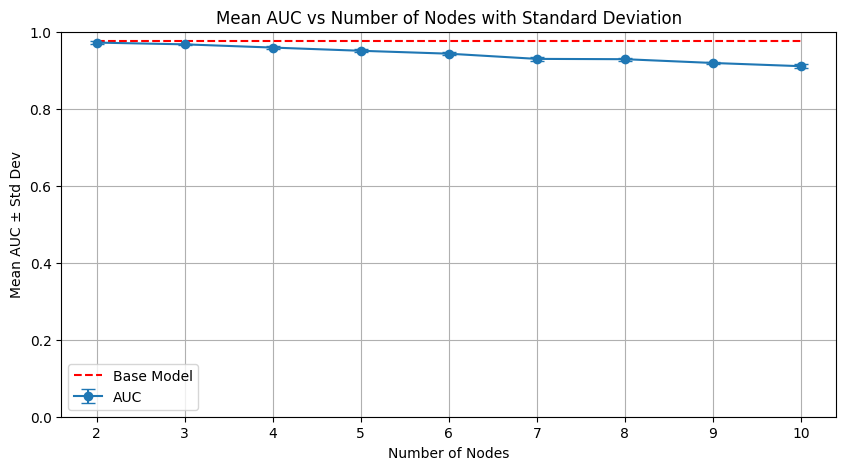

In [76]:
# Plotting Mean AUC with Standard Deviation
plt.figure(figsize=(10, 5))
plt.errorbar(n_nodes, mean_auc, yerr=std_auc, fmt='-o', capsize=5, label='AUC')
# Base model is a constant baseline (no error bars needed):
plt.plot(
    n_nodes,
    [base_perf[1]] * len(n_nodes),
    'r--',
    label='Base Model'
)

plt.xlabel('Number of Nodes')
plt.ylabel('Mean AUC ± Std Dev')
plt.title('Mean AUC vs Number of Nodes with Standard Deviation')
plt.ylim(0.0, 1)
plt.xticks(n_nodes)
plt.legend()
plt.grid(True)
plt.show()

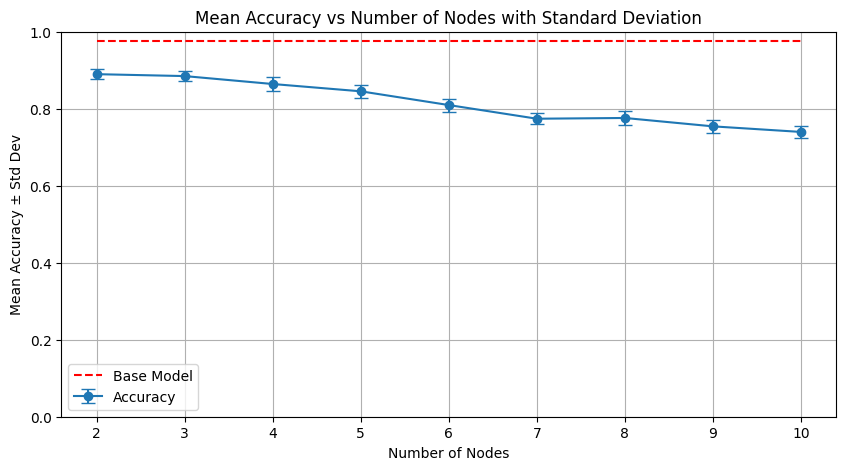

In [77]:
# Plotting Mean Accuracy with Standard Deviation
plt.figure(figsize=(10, 5))
plt.errorbar(n_nodes, mean_accuracy, yerr=std_accuracy, fmt='-o', capsize=5, label='Accuracy')

# Base model is a constant baseline (no error bars needed):
plt.plot(
    n_nodes,
    [base_perf[1]] * len(n_nodes),
    'r--',
    label='Base Model'
)

plt.xlabel('Number of Nodes')
plt.ylabel('Mean Accuracy ± Std Dev')
plt.title('Mean Accuracy vs Number of Nodes with Standard Deviation')
plt.ylim(0.0, 1)
plt.xticks(n_nodes)
plt.legend()
plt.grid(True)
plt.show()

# Experiment 3

In [102]:
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import model_from_json

In [103]:

# Function to make data JSON serializable
def make_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_serializable(v) for v in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    else:
        return obj

In [105]:
# Define the output directory for Experiment 3
experiment_dir = os.path.join('data', 'Experiment 3')
os.makedirs(experiment_dir, exist_ok=True)

# Initialize a list to hold all experiment results
all_experiment_results = []
num_iterations = 20
num_shared_labels_range = range(0, 14)  # 0-13
n_nodes = 2

for iteration in range(num_iterations):
    print(f"\n--- Iteration {iteration+1}/{num_iterations} ---")
    
    # Per-iteration storage
    iteration_results = []
    
    # Create iteration directory
    iteration_dir = os.path.join(experiment_dir, f'iteration_{iteration+1}')
    os.makedirs(iteration_dir, exist_ok=True)

    for shared_labels in num_shared_labels_range:
        print(f"  Testing shared_labels={shared_labels}...")
        
        # Initialize nodes and model
        nodes = create_FL_Datasets(X_train, y_train, n_nodes, shared_labels)
        global_model = create_mlp_model(allEmbeddings.shape[1], labels.shape[1])
        max_label = labels.shape[1] - 1

        # Federated training
        for round in range(num_rounds):
            for node in nodes:
                node['classifier'].fit(node['X_train'], node['y_train'], 
                                      epochs=num_epochs, verbose=0)
            global_model, nodes = surgical_aggregation(nodes, max_label, global_model)

        # Evaluation
        perf = global_model.evaluate(X_test, y_test, verbose=0)
        metrics = get_metrics(global_model, X_test, y_test, labels)
        label_names = [node['label_names'].tolist() for node in nodes]

        # Create result entry
        result = {
            'shared_labels': shared_labels,
            'perf': make_serializable(perf),
            'metrics': make_serializable(metrics),
            'label_names': make_serializable(label_names)
        }
        
        # Save per-configuration files
        config_dir = os.path.join(iteration_dir, f'shared_labels_{shared_labels}')
        os.makedirs(config_dir, exist_ok=True)
        
        # Save metrics
        with open(os.path.join(config_dir, 'metrics.json'), 'w') as f:
            json.dump(result, f)
        
        # Save model
        model_path = os.path.join(config_dir, 'global_model')
        global_model.save(model_path+'.h5')  # Saves both architecture and weights
        
        iteration_results.append(result)

    # Save iteration-level aggregation
    with open(os.path.join(iteration_dir, 'iteration_summary.json'), 'w') as f:
        json.dump(make_serializable(iteration_results), f)
    
    all_experiment_results.extend(iteration_results)

# Save global results
with open(os.path.join(experiment_dir, 'all_experiment_results.json'), 'w') as f:
    json.dump(make_serializable(all_experiment_results), f)

print("\nExperiment complete! Results saved to:", experiment_dir)


--- Iteration 1/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 2/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 3/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 4/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 5/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 6/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 7/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 8/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 9/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 10/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 11/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 12/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step



--- Iteration 13/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 



--- Iteration 14/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 15/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 16/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 17/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 18/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 19/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



--- Iteration 20/20 ---
  Testing shared_labels=0...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=1...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=2...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=3...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=4...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=5...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=6...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=7...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=8...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=9...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=10...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=11...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=12...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


  Testing shared_labels=13...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 



Experiment complete! Results saved to: data\Experiment 3


In [81]:
# Define the output directory for Experiment 3
experiment_dir = os.path.join('data', 'Experiment 3')
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

# Initialize a list to hold all experiment results
all_experiment_results = []
num_iterations = 20
num_shared_labels_range = range(0, 14)  # From 0 to 13
n_nodes = 2  # Number of nodes fixed at 2
test_size = 0.2
num_rounds = 20
num_epochs = 1

for iteration in range(num_iterations):
    print(f"Running iteration {iteration + 1}...")
    
    # Initialize containers to store results for this iteration
    iteration_global_models = []
    iteration_perf = []
    iteration_label_names = []
    iteration_metrics = []
    
    # Loop over shared labels
    for shared_labels in num_shared_labels_range:
        print(f"  Running with {shared_labels} shared labels...")
        
        # Initialize nodes and model
        nodes = create_FL_Datasets(X_train, y_train, n_nodes, shared_labels)
        global_model = create_mlp_model(allEmbeddings.shape[1], labels.shape[1])
        max_label = labels.shape[1] - 1
        
        # Perform federated learning
        for round in range(num_rounds):
            for node in nodes:
                node['classifier'].fit(node['X_train'], node['y_train'], epochs=num_epochs, verbose=0)
            global_model, nodes = surgical_aggregation(nodes, max_label, global_model)
        
        perf = global_model.evaluate(X_test, y_test, verbose=0)
        iteration_global_models.append(global_model)
        iteration_perf.append(perf)
        label_names = [node['label_names'].tolist() for node in nodes]
        iteration_label_names.append(label_names)
        metrics = get_metrics(global_model, X_test, y_test, labels)
        iteration_metrics.append(metrics)
        
    # Convert data to JSON-serializable format
    iteration_perf_serializable = make_serializable(iteration_perf)
    iteration_label_names_serializable = make_serializable(iteration_label_names)
    iteration_metrics_serializable = make_serializable(iteration_metrics)
        
    # Store results of this iteration in a specific folder
    iteration_dir = os.path.join(output_dir, f'iteration_{iteration + 1}')
    os.makedirs(iteration_dir, exist_ok=True)
    
    # Save performance metrics as JSON
    with open(os.path.join(iteration_dir, 'iteration_perf.json'), 'w') as f:
        json.dump(iteration_perf_serializable, f)
    
    # Save label names as JSON
    with open(os.path.join(iteration_dir, 'iteration_label_names.json'), 'w') as f:
        json.dump(iteration_label_names_serializable, f)
    
    # Save detailed metrics as JSON
    with open(os.path.join(iteration_dir, 'iteration_metrics.json'), 'w') as f:
        json.dump(iteration_metrics_serializable, f)
    
    # Save global models
    models_dir = os.path.join(iteration_dir, 'models')
    os.makedirs(models_dir, exist_ok=True)
    for idx, model in enumerate(iteration_global_models):
        # Save model architecture to JSON
        model_json = model.to_json()
        with open(os.path.join(models_dir, f'global_model_{idx}.json'), 'w') as json_file:
            json_file.write(model_json)
        # Save model weights (weights cannot be saved as JSON)
        model.save_weights(os.path.join(models_dir, f'global_model_{idx}.weights.h5'))
    
    # Save iteration-level data for comparison
    experiment_data = {
        'perf': iteration_perf_serializable,
        'label_names': iteration_label_names_serializable,
        'metrics': iteration_metrics_serializable
    }
    all_experiment_results.append(experiment_data)

# Save all experiment results as JSON
all_experiment_results_serializable = make_serializable(all_experiment_results)
with open(os.path.join(output_dir, 'all_experiment_results.json'), 'w') as f:
    json.dump(all_experiment_results_serializable, f)

print("All 20 iterations are complete, and results are saved.")


Running iteration 1...
  Running with 0 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 1 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Running with 2 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Running with 3 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 4 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 5 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 6 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 7 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
  Running with 8 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 9 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 10 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 11 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 12 shared labels...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
  Running with 

## Visualisation

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize containers for metrics
shared_labels_list = list(range(0, 14))
mean_auc_list = []
std_auc_list = []
mean_accuracy_list = []
std_accuracy_list = []

# For each shared_labels value, collect metrics across iterations
for shared_labels in shared_labels_list:
    auc_values = []
    accuracy_values = []
    for iteration_data in all_experiment_results:
        # Find the result for this shared_labels value
        shared_labels_result = next((res for res in iteration_data['results'] if res['shared_labels'] == shared_labels), None)
        if shared_labels_result:
            perf = shared_labels_result['perf']
            metrics = shared_labels_result['metrics']
            # Assuming perf[1] is AUC
            auc_values.append(perf[1])
            # Assuming overall accuracy is available in metrics
            accuracy_values.append(metrics['Overall']['Accuracy'])
    # Calculate mean and std dev for this shared_labels value
    mean_auc_list.append(np.mean(auc_values))
    std_auc_list.append(np.std(auc_values))
    mean_accuracy_list.append(np.mean(accuracy_values))
    std_accuracy_list.append(np.std(accuracy_values))

# Convert lists to NumPy arrays
mean_auc_array = np.array(mean_auc_list)
std_auc_array = np.array(std_auc_list)
mean_accuracy_array = np.array(mean_accuracy_list)
std_accuracy_array = np.array(std_accuracy_list)






KeyError: 'results'

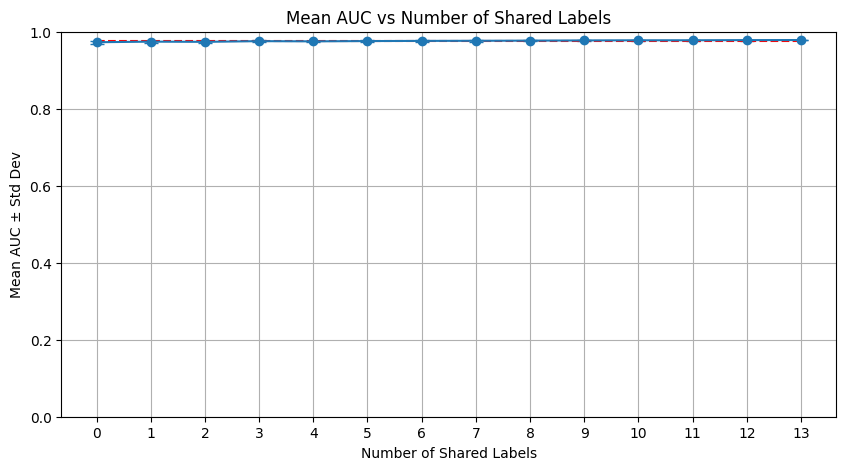

In [107]:
# Plotting Mean AUC with Standard Deviation
plt.figure(figsize=(10, 5))
plt.errorbar(shared_labels_list, mean_auc_array, yerr=std_auc_array, fmt='-o', capsize=5)
plt.xlabel('Number of Shared Labels')
plt.ylabel('Mean AUC ± Std Dev')
plt.title('Mean AUC vs Number of Shared Labels')
plt.plot(
    shared_labels_list,
    [base_perf[1]] * len(shared_labels_list),
    'r--',
    label='Base Model'
)
plt.ylim(0.0, 1)
plt.xticks(shared_labels_list)
plt.grid(True)
plt.show()

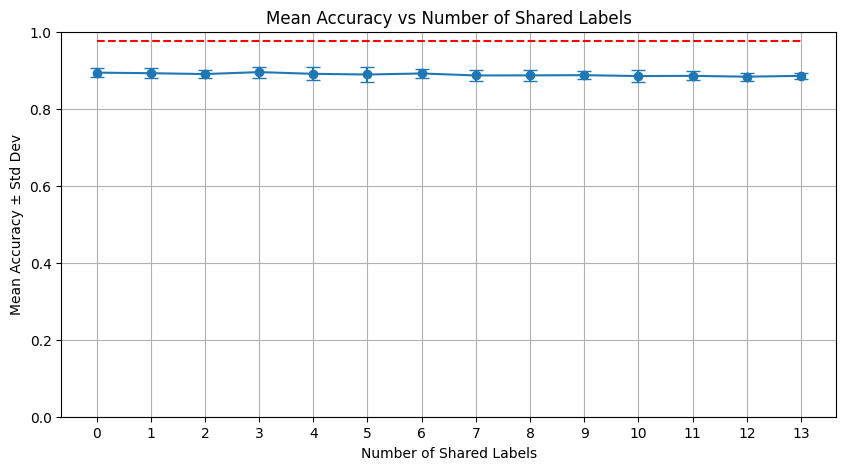

In [108]:
# Plotting Mean Accuracy with Standard Deviation
plt.figure(figsize=(10, 5))
plt.errorbar(shared_labels_list, mean_accuracy_array, yerr=std_accuracy_array, fmt='-o', capsize=5)
plt.xlabel('Number of Shared Labels')
plt.ylabel('Mean Accuracy ± Std Dev')
plt.title('Mean Accuracy vs Number of Shared Labels')
plt.plot(
    shared_labels_list,
    [base_perf[1]] * len(shared_labels_list),
    'r--',
    label='Base Model'
)
plt.xticks(shared_labels_list)
plt.ylim(0.0, 1)
plt.grid(True)
plt.show()

# T-Tests

In [3]:
from scipy.stats import ttest_rel
def perform_t_tests(results, label_columns, metrics=['Accuracy', 'Sensitivity', 'Specificity', 'AUC']):
    t_test_results = {}

    configs = list(results.keys())
    for i in range(len(configs)):
        for j in range(i + 1, len(configs)):
            config_1 = configs[i]
            config_2 = configs[j]
            comparison_key = f'{config_1} vs {config_2}'
            t_test_results[comparison_key] = {}

            for metric in metrics:
                data_config_1 = results[config_1][metric]
                data_config_2 = results[config_2][metric]

                # Perform the paired t-test
                t_stat, p_value = ttest_rel(data_config_1, data_config_2)
                t_test_results[comparison_key][metric] = {'t_stat': t_stat, 'p_value': p_value}

    return t_test_results

## Experiment 2

In [43]:
import glob
import os
import json
experiment_dir='data\Experiment 2'
results={}
metrics=['Accuracy', 'Sensitivity', 'Specificity', 'AUC']
label_list= ['Two Shared', 'Three Shared', 'Four Shared', 'Five Shared', 'Six Shared', 'Seven Shared', 'Eight Shared', 'Nine Shared', 'Ten Shared']
results = {
    label: {
        "Accuracy": [],
        "Sensitivity": [],
        "Specificity": [],
        "AUC": []
    } for label in label_list
}
for count in range(1,21):
    with open(experiment_dir+'\iteration_'+str(count)+'\iteration_metrics.json', 'r') as f:
        data = json.load(f)
    for item,label_name in zip(data,label_list):
        for metrics, value in item['Overall'].items():
            results[label_name][metrics].append(value)
print(results)

{'Two Shared': {'Accuracy': [0.892433623675097, 0.8964214503095813, 0.8968412215342638, 0.901353762199601, 0.885507398467835, 0.8633644663658304, 0.8972609927589463, 0.8923286808689265, 0.8760625459124778, 0.8950571938293629, 0.8819393430580333, 0.8882359114282715, 0.8887606254591248, 0.9055514744464267, 0.8710252912162872, 0.8914891384195615, 0.8877111973974183, 0.8731241473396998, 0.890964424388708, 0.9199286388918041], 'Sensitivity': [0.9378099499395649, 0.9235591419024142, 0.941121337735055, 0.92075340068386, 0.944749419597518, 0.9591368609620484, 0.9440224273551165, 0.9507758713308877, 0.967628509734425, 0.9062729892013178, 0.9515158814758509, 0.9216943514145511, 0.9409067893172813, 0.9268378880853103, 0.964732527389402, 0.9304474371074354, 0.9265614751839296, 0.9592588097766659, 0.9245955635191361, 0.892225436283137], 'Specificity': [0.8934184184999743, 0.8971827793386191, 0.8935053034102024, 0.9020159541047073, 0.8845338481919411, 0.8602276776738418, 0.8967926220195265, 0.891735

In [46]:
with open(r'data\Experiment 2\experiment_2_results.json', 'w') as f:
     json.dump(results, f, indent=4)

In [33]:
t_test_result=perform_t_tests(results,label_list)

In [34]:
print(t_test_result)

{'Two Shared vs Three Shared': {'Accuracy': {'t_stat': 1.2784566867664902, 'p_value': 0.2164854245184164}, 'Sensitivity': {'t_stat': 5.242067823508331, 'p_value': 4.6431086177186416e-05}, 'Specificity': {'t_stat': 0.9244677644459829, 'p_value': 0.3668358476161716}, 'AUC': {'t_stat': 4.002568305478893, 'p_value': 0.0007617104967921659}}, 'Two Shared vs Four Shared': {'Accuracy': {'t_stat': 4.589967383332662, 'p_value': 0.00019995346316883177}, 'Sensitivity': {'t_stat': 4.797012740535205, 'p_value': 0.0001253056467799864}, 'Specificity': {'t_stat': 4.292183162912646, 'p_value': 0.00039332069656421387}, 'AUC': {'t_stat': 13.080113079581533, 'p_value': 5.963605871725464e-11}}, 'Two Shared vs Five Shared': {'Accuracy': {'t_stat': 9.332261922838738, 'p_value': 1.5830759546064837e-08}, 'Sensitivity': {'t_stat': 6.84332719447678, 'p_value': 1.5696705150902417e-06}, 'Specificity': {'t_stat': 8.457630107057449, 'p_value': 7.264725432814266e-08}, 'AUC': {'t_stat': 17.478560085703396, 'p_value': 3

In [35]:
import pandas as pd
import openpyxl

# Create a list of rows, where each row is a dict that will become one row in the final DataFrame
rows = []

for shared_label, metrics_dict in t_test_result.items():
    print(shared_label)
    print(metrics_dict['Accuracy'])
    # Each "metrics_dict" has keys like 'Accuracy', 'Sensitivity', 'Specificity', 'AUC'.
    # Each of these keys corresponds to a list of 20 floats (in your example).
    for metric_name, metric_values in metrics_dict.items():
        # metric_values should be {"t_stat": X, "p_value": Y}
        row = {
            "Shared Label": shared_label,
            "Metric": metric_name,
            "t_stat": metric_values["t_stat"],
            "p_value": metric_values["p_value"]
        }
        rows.append(row)
# Convert the list of dicts into a pandas DataFrame
df = pd.DataFrame(rows)

# Now export this DataFrame to Excel
df.to_excel(r"data\t-tests\Experiment 2 Result.xlsx", index=False)

print("Data successfully exported")

Two Shared vs Three Shared
{'t_stat': 1.2784566867664902, 'p_value': 0.2164854245184164}
Two Shared vs Four Shared
{'t_stat': 4.589967383332662, 'p_value': 0.00019995346316883177}
Two Shared vs Five Shared
{'t_stat': 9.332261922838738, 'p_value': 1.5830759546064837e-08}
Two Shared vs Six Shared
{'t_stat': 16.026743828643195, 'p_value': 1.7080409405520174e-12}
Two Shared vs Seven Shared
{'t_stat': 28.58746397054934, 'p_value': 4.4397911680196393e-17}
Two Shared vs Eight Shared
{'t_stat': 30.41757877555025, 'p_value': 1.3988330193527566e-17}
Two Shared vs Nine Shared
{'t_stat': 27.8867636802859, 'p_value': 7.040356638872137e-17}
Two Shared vs Ten Shared
{'t_stat': 31.090978100261196, 'p_value': 9.299731759710495e-18}
Three Shared vs Four Shared
{'t_stat': 3.4270322753177576, 'p_value': 0.002826184129469092}
Three Shared vs Five Shared
{'t_stat': 7.614359930525394, 'p_value': 3.4633724167840686e-07}
Three Shared vs Six Shared
{'t_stat': 16.808690126005715, 'p_value': 7.312980502074557e-13

## Experiment 3

In [47]:
import glob
import os
import json
experiment_dir='data\Experiment 3'
results={}
metrics=['Accuracy', 'Sensitivity', 'Specificity', 'AUC']
label_list= ['Two Shared', 'Three Shared', 'Four Shared', 'Five Shared', 'Six Shared', 'Seven Shared', 'Eight Shared', 'Nine Shared', 'Ten Shared','Eleven Shared', 'Twelve Shared', 'Thirteen Shared']
results = {
    label: {
        "Accuracy": [],
        "Sensitivity": [],
        "Specificity": [],
        "AUC": []
    } for label in label_list
}
for count in range(1,21):
    with open(experiment_dir+'\iteration_'+str(count)+'\iteration_summary.json', 'r') as f:
        data = json.load(f)
    for item,label_name in zip(data,label_list):
        for metrics, value in item['metrics']['Overall'].items():
            results[label_name][metrics].append(value)
print(results)



    

{'Two Shared': {'Accuracy': [0.9024031902613076, 0.9007241053625774, 0.8848777416308112, 0.9051317032217441, 0.8851925700493232, 0.8964214503095813, 0.8733340329520412, 0.8933781089306329, 0.8788960016790848, 0.8749081750446007, 0.897365935565117, 0.8957917934725574, 0.9116381572043237, 0.9025081330674781, 0.8790009444852553, 0.889285339489978, 0.8975758211774582, 0.9059712456711093, 0.9086997586315457, 0.8870815405603948], 'Sensitivity': [0.9345180286342989, 0.9408234960848667, 0.941616720702582, 0.919558907341566, 0.9444555657317684, 0.9381085766389147, 0.9418909458483251, 0.9445012153922978, 0.9581669392866252, 0.9458206644314644, 0.907829633929924, 0.9408646429068628, 0.9133968980460216, 0.9341083675817701, 0.9342175537419828, 0.9141553277132741, 0.9344311609760473, 0.9189536563435803, 0.9285495788110505, 0.9601261745742165], 'Specificity': [0.9036786480061214, 0.8999972452231698, 0.8825219927237993, 0.9040043462854899, 0.8837449288800223, 0.8935996502369475, 0.8730181470183251, 0.

In [49]:
with open(r'data\Experiment 3\experiment_3_results.json', 'w') as f:
     json.dump(results, f, indent=4)

In [48]:
t_test_result=perform_t_tests(results,label_list)

In [38]:
print(t_test_result)

{'Two Shared vs Three Shared': {'Accuracy': {'t_stat': 0.3446121141452313, 'p_value': 0.7341711693930921}, 'Sensitivity': {'t_stat': -0.33350822179507544, 'p_value': 0.7424031279010326}, 'Specificity': {'t_stat': 0.26919806545004815, 'p_value': 0.790678904842477}, 'AUC': {'t_stat': -0.35657997550545234, 'p_value': 0.7253355502415557}}, 'Two Shared vs Four Shared': {'Accuracy': {'t_stat': -0.5440167245245956, 'p_value': 0.5927572475216676}, 'Sensitivity': {'t_stat': 0.1890945590740979, 'p_value': 0.8520239952476714}, 'Specificity': {'t_stat': -0.5976384071938732, 'p_value': 0.5571378847598114}, 'AUC': {'t_stat': -0.5422408850003376, 'p_value': 0.593955981036038}}, 'Two Shared vs Five Shared': {'Accuracy': {'t_stat': -2.10701221745768e-15, 'p_value': 0.9999999999999983}, 'Sensitivity': {'t_stat': -0.4041955165223198, 'p_value': 0.6905825095545748}, 'Specificity': {'t_stat': -0.034688492341972715, 'p_value': 0.9726899784505503}, 'AUC': {'t_stat': -1.307974919989184, 'p_value': 0.206486436

In [39]:
import pandas as pd
import openpyxl

# Create a list of rows, where each row is a dict that will become one row in the final DataFrame
rows = []

for shared_label, metrics_dict in t_test_result.items():
    print(shared_label)
    print(metrics_dict['Accuracy'])
    # Each "metrics_dict" has keys like 'Accuracy', 'Sensitivity', 'Specificity', 'AUC'.
    # Each of these keys corresponds to a list of 20 floats (in your example).
    for metric_name, metric_values in metrics_dict.items():
        # metric_values should be {"t_stat": X, "p_value": Y}
        row = {
            "Shared Label": shared_label,
            "Metric": metric_name,
            "t_stat": metric_values["t_stat"],
            "p_value": metric_values["p_value"]
        }
        rows.append(row)
# Convert the list of dicts into a pandas DataFrame
df = pd.DataFrame(rows)

# Now export this DataFrame to Excel
df.to_excel(r"data\t-tests\Experiment 3 Result.xlsx", index=False)

print("Data successfully exported")


Two Shared vs Three Shared
{'t_stat': 0.3446121141452313, 'p_value': 0.7341711693930921}
Two Shared vs Four Shared
{'t_stat': -0.5440167245245956, 'p_value': 0.5927572475216676}
Two Shared vs Five Shared
{'t_stat': -2.10701221745768e-15, 'p_value': 0.9999999999999983}
Two Shared vs Six Shared
{'t_stat': -0.10968387964645958, 'p_value': 0.9138102921558492}
Two Shared vs Seven Shared
{'t_stat': 0.6761781234204857, 'p_value': 0.5070757840693352}
Two Shared vs Eight Shared
{'t_stat': 0.8416747880211861, 'p_value': 0.41043910256374927}
Two Shared vs Nine Shared
{'t_stat': 1.173578797639295, 'p_value': 0.25506590752990427}
Two Shared vs Ten Shared
{'t_stat': 0.6433998439922596, 'p_value': 0.5276547246009475}
Two Shared vs Eleven Shared
{'t_stat': 1.5779115808485384, 'p_value': 0.13109032877829413}
Two Shared vs Twelve Shared
{'t_stat': 1.7576231169263101, 'p_value': 0.0949125822768463}
Two Shared vs Thirteen Shared
{'t_stat': 2.7109892454037556, 'p_value': 0.01385667556128961}
Three Shared v